
Training model for SKU_0
Epoch 1 Loss: 12646.0929
Epoch 2 Loss: 1756.7307
Epoch 3 Loss: 862.7873
Epoch 4 Loss: 512.3247
Epoch 5 Loss: 416.8073
Epoch 6 Loss: 303.2994
Epoch 7 Loss: 244.7705
Epoch 8 Loss: 199.1094
Epoch 9 Loss: 157.8778
Epoch 10 Loss: 118.8527
Epoch 11 Loss: 86.4339
Epoch 12 Loss: 62.8406
Epoch 13 Loss: 48.4515
Epoch 14 Loss: 41.8758
Epoch 15 Loss: 39.4916

Training model for SKU_1
Epoch 1 Loss: 8511.2509
Epoch 2 Loss: 1814.7259
Epoch 3 Loss: 966.3098
Epoch 4 Loss: 500.8586
Epoch 5 Loss: 408.0260
Epoch 6 Loss: 318.4210
Epoch 7 Loss: 254.3181
Epoch 8 Loss: 201.4867
Epoch 9 Loss: 158.8665
Epoch 10 Loss: 117.9345
Epoch 11 Loss: 86.3121
Epoch 12 Loss: 63.8133
Epoch 13 Loss: 48.9343
Epoch 14 Loss: 39.6625
Epoch 15 Loss: 37.0630

Training model for SKU_2
Epoch 1 Loss: 11496.2807
Epoch 2 Loss: 1880.8997
Epoch 3 Loss: 953.8089
Epoch 4 Loss: 532.9887
Epoch 5 Loss: 452.3929
Epoch 6 Loss: 319.6919
Epoch 7 Loss: 246.1159
Epoch 8 Loss: 191.5251
Epoch 9 Loss: 142.9216
Epoch 10 Loss: 

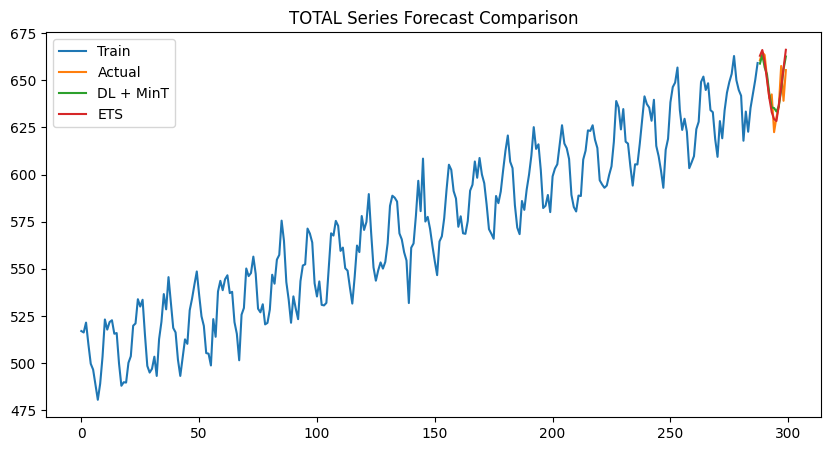

In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import matplotlib.pyplot as plt

np.random.seed(42)
torch.manual_seed(42)

# ============================================================
# 1. SYNTHETIC DATA
# ============================================================

def generate_hierarchical_data(n_periods=300):
    t = np.arange(n_periods)
    base_series = []
    for i in range(10):
        trend = 0.05 * t * np.random.uniform(0.8, 1.2)
        seasonality = 10 * np.sin(2 * np.pi * t / 12 + i)
        noise = np.random.normal(0, 2, n_periods)
        series = 50 + trend + seasonality + noise
        base_series.append(series)
    base_series = np.array(base_series)
    cat1 = base_series[:3].sum(axis=0)
    cat2 = base_series[3:7].sum(axis=0)
    cat3 = base_series[7:].sum(axis=0)
    total = base_series.sum(axis=0)
    data = pd.DataFrame(base_series.T, columns=[f"SKU_{i}" for i in range(10)])
    data["CAT_1"] = cat1
    data["CAT_2"] = cat2
    data["CAT_3"] = cat3
    data["TOTAL"] = total
    return data

# ============================================================
# 2. DATASET
# ============================================================

class TimeSeriesDataset(Dataset):
    def __init__(self, series, input_size=24, horizon=12):
        X, y = [], []
        for i in range(len(series) - input_size - horizon):
            X.append(series[i:i+input_size])
            y.append(series[i+input_size:i+input_size+horizon])
        self.X = torch.tensor(np.array(X), dtype=torch.float32)
        self.y = torch.tensor(np.array(y), dtype=torch.float32)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# ============================================================
# 3. N-BEATS MODEL
# ============================================================

class NBeatsBlock(nn.Module):
    def __init__(self, input_size, horizon, hidden_units=128):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_size, hidden_units),
            nn.ReLU(),
            nn.Linear(hidden_units, hidden_units),
            nn.ReLU()
        )
        self.backcast = nn.Linear(hidden_units, input_size)
        self.forecast = nn.Linear(hidden_units, horizon)
    def forward(self, x):
        h = self.fc(x)
        return self.backcast(h), self.forecast(h)

class NBeats(nn.Module):
    def __init__(self, input_size, horizon, n_blocks=3):
        super().__init__()
        self.blocks = nn.ModuleList([NBeatsBlock(input_size, horizon) for _ in range(n_blocks)])
        self.horizon = horizon
    def forward(self, x):
        residual = x
        forecast = torch.zeros(x.size(0), self.horizon)
        for block in self.blocks:
            backcast, f = block(residual)
            residual = residual - backcast
            forecast = forecast + f
        return forecast

# ============================================================
# 4. TRAINING
# ============================================================

def train_model(series):
    dataset = TimeSeriesDataset(series)
    loader = DataLoader(dataset, batch_size=32, shuffle=True)
    model = NBeats(input_size=24, horizon=12)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    loss_fn = nn.MSELoss()
    model.train()
    for epoch in range(15):
        epoch_loss = 0
        for X, y in loader:
            X = X.view(X.size(0), -1)
            optimizer.zero_grad()
            pred = model(X)
            loss = loss_fn(pred, y)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        print(f"Epoch {epoch+1} Loss: {epoch_loss:.4f}")
    return model

# ============================================================
# 5. OLS MinT RECONCILIATION
# ============================================================

def mint_reconciliation(bottom_forecasts):
    """
    bottom_forecasts: (10, horizon) → only SKUs
    Returns: reconciled forecasts for TOTAL + CAT_1 + CAT_2 + CAT_3 + SKUs
    """
    S = np.vstack([
        np.ones((1,10)),             # TOTAL
        np.array([
            [1,1,1,0,0,0,0,0,0,0],  # CAT_1
            [0,0,0,1,1,1,1,0,0,0],  # CAT_2
            [0,0,0,0,0,0,0,1,1,1]   # CAT_3
        ]),
        np.eye(10)                   # SKU_0 ... SKU_9
    ])  # shape = (14,10)

    reconciled_all = S @ bottom_forecasts   # shape = (14,horizon)
    return reconciled_all

# ============================================================
# 6. ETS BASELINE
# ============================================================

def ets_forecast(series, horizon=12):
    model = ExponentialSmoothing(series, trend="add", seasonal="add", seasonal_periods=12).fit()
    return model.forecast(horizon)

# ============================================================
# 7. METRICS
# ============================================================

def smape(y_true, y_pred):
    return np.mean(2*np.abs(y_pred-y_true)/(np.abs(y_true)+np.abs(y_pred)+1e-8))

def mase(insample, y_true, y_pred, seasonality=12):
    d = np.mean(np.abs(insample[seasonality:] - insample[:-seasonality]))
    return np.mean(np.abs(y_true-y_pred)) / (d + 1e-8)

# ============================================================
# 8. PLOTTING
# ============================================================

def plot_forecasts(train_total, test_total, dl_forecast, ets_pred):
    plt.figure(figsize=(10,5))
    plt.plot(train_total, label="Train")
    plt.plot(range(len(train_total), len(train_total)+len(test_total)), test_total, label="Actual")
    plt.plot(range(len(train_total), len(train_total)+len(dl_forecast)), dl_forecast, label="DL + MinT")
    plt.plot(range(len(train_total), len(train_total)+len(ets_pred)), ets_pred, label="ETS")
    plt.legend()
    plt.title("TOTAL Series Forecast Comparison")
    plt.show()

# ============================================================
# 9. SUMMARY TABLE
# ============================================================

def print_forecast_summary(reconciled):
    levels = ["TOTAL","CAT_1","CAT_2","CAT_3"] + [f"SKU_{i}" for i in range(10)]
    df = pd.DataFrame(reconciled, index=levels, columns=[f"T+{i+1}" for i in range(reconciled.shape[1])])
    print("\n================ RECONCILED FORECAST SUMMARY ================")
    print(df.round(2))

# ============================================================
# 10. MAIN PIPELINE
# ============================================================

def main():
    data = generate_hierarchical_data()
    train = data.iloc[:-12]
    test = data.iloc[-12:]

    forecasts = []

    # Train N-BEATS for each SKU
    for col in [f"SKU_{i}" for i in range(10)]:
        print(f"\nTraining model for {col}")
        model = train_model(train[col].values)
        model.eval()
        with torch.no_grad():
            input_seq = torch.tensor(train[col].values[-24:], dtype=torch.float32).unsqueeze(0)
            forecast = model(input_seq).numpy().flatten()
        forecasts.append(forecast)

    bottom_forecasts = np.array(forecasts)   # (10,horizon)

    # ✅ MinT reconciliation (OLS)
    reconciled = mint_reconciliation(bottom_forecasts)

    # ETS baseline
    ets_pred = ets_forecast(train["TOTAL"])
    dl_smape = smape(test["TOTAL"].values, reconciled[0])
    ets_smape = smape(test["TOTAL"].values, ets_pred.values)

    # Print summary
    print_forecast_summary(reconciled)
    print("\nSMAPE (DL + MinT TOTAL):", dl_smape)
    print("SMAPE (ETS TOTAL):", ets_smape)
    print("MASE (DL TOTAL):", mase(train["TOTAL"].values, test["TOTAL"].values, reconciled[0]))

    # Plot
    plot_forecasts(train["TOTAL"].values, test["TOTAL"].values, reconciled[0], ets_pred.values)

if __name__ == "__main__":
    main()
